In [8]:
import pandas as pd
from pathlib import Path
import pandas as pd
import fileinput
import numpy as np

In [4]:
datadir = Path('../data/raw_data')
data17dir = datadir.joinpath('AEM_data_2017_avg')
data19dir = datadir.joinpath('AEM_data_2019_avg')

data17 = datadir.joinpath('AEM_data_2017','MCWD3_SCI1i_MOD_dat.xyz')
data19 = datadir.joinpath('AEM_data_2019','MCWD19_SCI8i_MOD_dat.xyz')

In [5]:
def rm_leadspace(f_name):
    for line in fileinput.input(f_name,inplace = True):
        if line.startswith('/ '):
            print(line.lstrip('/ ').rstrip('\n'))
        else:
            print(line.rstrip('\n'))
    fileinput.close()
    
xyz_dirs = (data17.parent,data19.parent,data17dir,data19dir)

for d in xyz_dirs:
    for f in d.iterdir():
        if f.as_posix().endswith('xyz'):
            rm_leadspace(f.as_posix())

In [10]:
df17 = pd.read_csv(data17,header=20,delim_whitespace=True)
df19 = pd.read_csv(data19,header=20,delim_whitespace=True)

df17 = df17.assign(skytem_type=304)
df19 = df19.assign(skytem_type=312)
# df = pd.concat((df17,df19),sort=False)

line = 100501

header=20
for i,f in enumerate(data17dir.iterdir()):
    if i==0:
        df = pd.read_csv(f,header=header,delim_whitespace=True)
        df = df.assign(FLIGHT_NO=f.name.split('_')[0])
        df = df.assign(skytem_type=304)
    else:
        df_temp = pd.read_csv(f,header=header,delim_whitespace=True)
        df_temp = df_temp.assign(FLIGHT_NO=f.name.split('_')[0])
        df_temp = df_temp.assign(skytem_type=304)
        df = pd.concat((df,df_temp))


In [11]:
df = df.reset_index()
df = df.rename(columns={'index':'index_orig'})
df.index = df.index.astype(np.float)

#### Weave in blank HM soundings into repeated LM (and LM into repeated HM)

In [13]:
flag=0


dbdt_inds = np.array([key.startswith('DBDT') for key in df.keys()], dtype=bool)

#Do this line-by-line
for line_tmp in df.LINE_NO.unique():
    df_tmp = df.loc[df.LINE_NO==line_tmp]
    repeat_inds = np.logical_and(df.CHANNEL_NO.diff()==0,df.LINE_NO==line_tmp)
    repeat_channel = df.CHANNEL_NO.loc[repeat_inds].values
    new_channel = np.asarray([2 if v==1 else 1 for v in repeat_channel])
    repeat_info = df.loc[repeat_inds,:].copy()
    repeat_info.loc[:,dbdt_inds] = 9999
    repeat_info.loc[:,'CHANNEL_NO'] = new_channel

    #If HM or LM is repeated, weave in an empty (all 9999) sounding  
    ind_list = repeat_info.index.tolist()
    for i,ind in enumerate(repeat_info.index):
        ind_list[i] += -0.5
    repeat_info.index = ind_list
    
    #append the new info and sort
    df_tmp = df_tmp.append(repeat_info)
    df_tmp = df_tmp.sort_index()


    #Verify that line starts w/ LM  and ends w/ HM
    last_ind = df_tmp.index.max()
    first_ind = df_tmp.index.min()
    if df_tmp.loc[last_ind].CHANNEL_NO==1:
        row = df_tmp.loc[last_ind].copy()
        row.CHANNEL_NO = 2
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[last_ind+.5] = row
    if df_tmp.loc[first_ind].CHANNEL_NO==2:
        row = df_tmp.loc[first_ind].copy()
        row.CHANNEL_NO = 1
        row.loc[dbdt_inds] = 9999
        df_tmp.loc[first_ind-.5] = row

    #Append onto df_new
    if flag==0:
        df_new = df_tmp.copy()
        flag=1
    else:
        df_new = df_new.append(df_tmp)

df = df_new.copy()
df = df.sort_index()
df.drop(df.loc[df.LINE_NO==0].index, inplace=True)

### Assign INVALT to the input data by nearest neighbor (takes a while)

In [107]:
def mindist(x,y,xarray,yarray,minthresh=-1, maxthresh=30): 
    return min((val, idx) for (idx, val) in enumerate(np.sqrt((x-xarray)**2 + (y-yarray)**2)))

invalt_col = int(np.argwhere(df17.columns=='INVALT'))
invalt=np.zeros(len(df))
for i,(x,y) in enumerate(df.loc[:,['UTMX','UTMY']].values):
    if i%5000==0:
        print('iteration {} of {}'.format(i,len(df)))
#     print(x,y)
    _,idx = mindist(x,y,df17.X.values,df17.Y.values)
    invalt[i]=df17.iloc[idx,invalt_col]

df = df.assign(INVALT=invalt)


iteration 0 of 25813
iteration 5000 of 25813
iteration 10000 of 25813
iteration 15000 of 25813
iteration 20000 of 25813
iteration 25000 of 25813


In [38]:
zeroinds = df[df.CHANNEL_NO.diff()==0].index

df.loc[zeroinds]

,index_orig,TIMESTAMP,LINE_NO,UTMX,UTMY,ELEVATION,CHANNEL_NO,RX_ALTITUDE,RX_ALTITUDE_STD,TX_ALTITUDE,...,DBDT_STD_Ch2GT30,DBDT_STD_Ch2GT31,DBDT_STD_Ch2GT32,DBDT_STD_Ch2GT33,DBDT_STD_Ch2GT34,DBDT_STD_Ch2GT35,DBDT_STD_Ch2GT36,DBDT_STD_Ch2GT37,FLIGHT_NO,skytem_type
249.0,250,42872.018779,202401,609561.1,4066948.3,3.94,1.0,28.48,0.109,26.45,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
249.0,249,42872.014294,201701,608684.5,4064949.6,13.85,1.0,49.69,0.080,49.43,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
249.5,249,42872.014294,201701,608684.5,4064949.6,13.85,2.0,49.69,0.080,49.43,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
249.5,250,42872.018779,202401,609561.1,4066948.3,3.94,2.0,28.48,0.109,26.45,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
659.0,660,42872.027836,202901,610333.7,4067967.9,3.83,1.0,31.01,0.100,29.07,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
659.0,659,42872.025868,202701,609781.2,4066938.1,3.88,1.0,38.06,0.080,36.72,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
659.5,659,42872.025868,202701,609781.2,4066938.1,3.88,2.0,38.06,0.080,36.72,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
659.5,660,42872.027836,202901,610333.7,4067967.9,3.83,2.0,31.01,0.100,29.07,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
996.5,997,42872.033478,203101,608464.2,4061405.7,27.62,1.0,37.02,0.081,37.55,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304
996.5,996,42872.033160,202901,608258.6,4061565.3,25.39,2.0,36.87,0.085,34.16,...,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.00000,9999.0,9999.00000,0516FL3pr,304


In [111]:
df.to_pickle(datadir.joinpath('processed_df.pkl'))

Text(0.5, 1.0, 'Inverted data: flight line 100501')

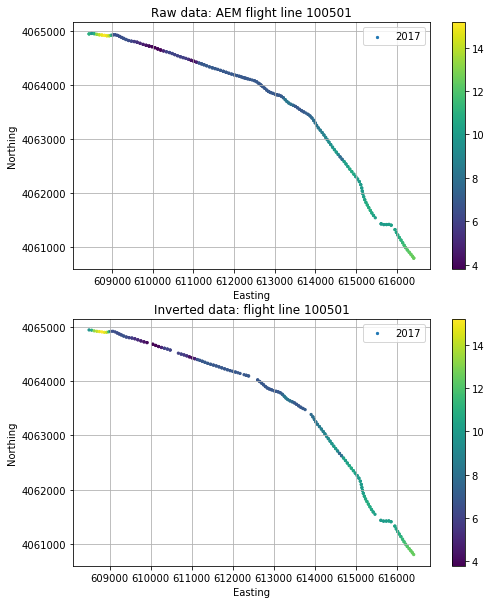

In [112]:
f,axs = plt.subplots(2,1,figsize=(8,10))
plt.sca(axs.flatten()[0])
ax = plt.gca()
plt.scatter(df.loc[df.LINE_NO==line,'UTMX'],
            df.loc[df.LINE_NO==line,'UTMY'],
            s=5,
            c=df.loc[df.LINE_NO==line,'ELEVATION'],
            label='2017')

plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Raw data: AEM flight line {}'.format(line))



plt.sca(axs.flatten()[1])
ax = plt.gca()
plt.scatter(df17.loc[df17.LINE==line,'X'],
            df17.loc[df17.LINE==line,'Y'],
            s=5,
            c=df17.loc[df17.LINE==line,'TOPO'],
            label='2017')
# plt.scatter(df19.loc[df19.LINE==line,'X'],df19.loc[df19.LINE==line,'Y'],s=1,c='k',label='2019')
plt.grid(True)
plt.colorbar()
plt.legend()
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.title('Inverted data: flight line {}'.format(line))

In [51]:
i_start_hm = 10
i_start_lm = 10

lm_inds = np.array(['DBDT_Ch1' in key.split('GT') for key in df.keys()], dtype=bool)
hm_inds = np.array(['DBDT_Ch2' in key.split('GT') for key in df.keys()], dtype=bool)
dbdt_inds = np.array([key.startswith('DBDT') for key in df.keys()], dtype=bool)

lm_header = (df.keys()[lm_inds])[i_start_lm:]
hm_header = (df.keys()[hm_inds])[i_start_hm:]

In [113]:
#TAKE THE LOCATION OF CHANNEL 1 FOR EACH SOUNDING
msk = np.logical_and(df.CHANNEL_NO.isin((1,)), df.LINE_NO == line)
xy = df.loc[msk,['UTMX', 'UTMY']].values
Line = df.LINE_NO.values
dem = df.loc[msk,'ELEVATION'].values[:]
height = df.loc[msk,'TX_ALTITUDE'].values[:]
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]
skytem_type = df.skytem_type.values

In [114]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_312.txt'))
waveform_lm_312 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_312.txt'))
time_input_currents_HM_312 = waveform_hm_312[:,0] 
input_currents_HM_312 = waveform_hm_312[:,1]
time_input_currents_LM_312 = waveform_lm_312[:,0] 
input_currents_LM_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-1.8E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.4E-06
MeaTimeDelay=6.000E-05
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [115]:
area = 342
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/hm_304.txt'))
waveform_lm_304 = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/lm_304.txt'))
time_input_currents_HM_304 = waveform_hm_304[:,0] 
input_currents_HM_304 = waveform_hm_304[:,1]
time_input_currents_LM_304 = waveform_lm_304[:,0] 
input_currents_LM_304 = waveform_lm_304[:,1]

time_gates = np.loadtxt(datadir.parent.joinpath('aem_waveform_marina/time_gates.txt'))
GateTimeShift=-2.1E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_304 = waveform_lm_304[:,0].max()
times_lm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_304

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_304 = waveform_hm_304[:,0].max()
times_hm_304 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_304    

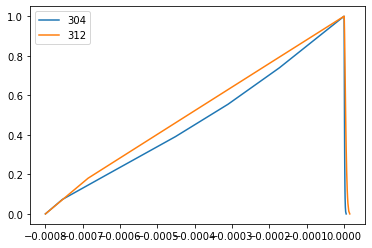

In [116]:
plt.plot(time_input_currents_LM_304, input_currents_LM_304,label='304')
plt.plot(time_input_currents_LM_312, input_currents_LM_312,label='312')
plt.legend()

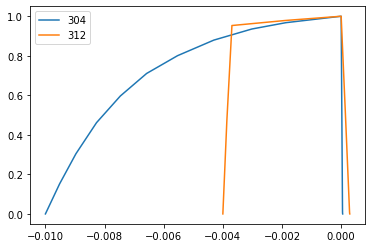

In [117]:
plt.plot(time_input_currents_HM_304, input_currents_HM_304,label='304')
plt.plot(time_input_currents_HM_312, input_currents_HM_312,label='312')
plt.legend()